In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import sys
sys.path.insert(0,"..")

import efficientnet.tfkeras
import numpy as np
import pandas as pd
import cv2
from tensorflow.keras.models import load_model
from keras.utils.data_utils import get_file
from PIL import Image

import matplotlib.pyplot as plt


IMAGE_SIZE = 224

classes = ['No Finding',
 'Enlarged \nCardiomediastinum',
 'Cardiomegaly',
 'Lung Opacity',
 'Lung Lesion',
 'Edema',
 'Consolidation',
 'Pneumonia',
 'Atelectasis',
 'Pneumothorax',
 'Pleural Effusion',
 'Pleural Other',
 'Fracture',
 'Support Devices']


def preprocess_image(uploaded_file):
    # Load image
    img_array = np.array(Image.open(uploaded_file))
    # Normalize to [0,1]
    img_array = img_array.astype('float32')
    img_array /= 255
    # Check that images are 2D arrays
    if len(img_array.shape) > 2:
        img_array = img_array[:, :, 0]
    # Convert to 3-channel
    img_array = np.stack((img_array, img_array, img_array), axis=-1)
    # Convert to array
    img_array = cv2.resize(img_array, (IMAGE_SIZE, IMAGE_SIZE))
    return img_array


def get_model():
    #URL = "https://github.com/hasibzunair/adversarial-lesions/releases/latest/download/MelaNet.h5"
    #weights_path = get_file(
    #            "NIH_EfficientNetB1_res128.h5",
    #            URL)
    weights_path = "weights/CheXpert_DenseNet121_res224.h5"
    model = load_model(weights_path, compile = False)
    return model

def make_prediction(file):
    # Preprocess input image
    image = preprocess_image(file)
    # Add batch axis
    image = np.expand_dims(image, 0)
    # Predict
    predictions = model.predict(image)
    return predictions


Using TensorFlow backend.


In [2]:
model = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [3]:
uploaded_file = "/home/hasib/Desktop/0ad9934b-bf35-497d-8082-1ecbc955d6de.jpg"

In [4]:
img = np.array(Image.open(uploaded_file))

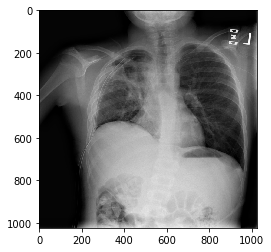

In [5]:
plt.imshow(img, cmap='gray')

In [6]:
predictions = make_prediction(uploaded_file)

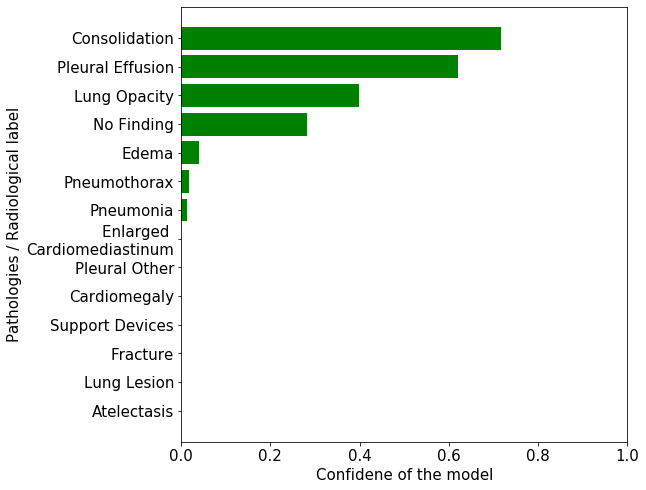

In [7]:
df = pd.DataFrame({'classes' : classes, 'predictions' : predictions[0]})
df = df.sort_values('predictions')

plt.figure(figsize=(8,8))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0, 1)
plt.barh(df['classes'], df['predictions'], color='green')
plt.xlabel('Confidene of the model', fontsize=15)
plt.ylabel('Pathologies / Radiological label', fontsize=15)
plt.show()